# Symmetry Reduced VQE

The first step is to find the blocks of a Hamiltonian which has have been reduced due to the application of some symmerty consideration.  Each block will then have an associated wavefunction,
$$ |\psi^b> = U(\phi^b_1,\phi^b_1,\ldots)|000\ldots> $$
where $|000\ldots>$ is the state in which $Q$ qubits are in their ground state with $Q$ deterimed by the size of the block $N$ as $Q = \log_2 N$ rounded up and $U$ is a linear transformation with some set of parameters $\{\phi^b_i\}$ which depend on the block.  

For this notebook we will use the linear transformation Anzatz from here: https://arxiv.org/abs/1907.01493.  It gives $U$ as applying y-rotations to each qubit, then coupling each qubit pair with a C-not gate and repreating. 
$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$
where the $\pm$ in the subscripts of the C-not gates alternates (see below for an exact definition).

The Hamiltonian might be block diagonal or it might have some nonzero off diagonal blocks.  In the most general case, the minimization function invovles wave functions from different blocks.  

$$ E = \sum_{a,b}<\psi^a|H_{ab}|\psi^b> $$

To minimize this function we will use the simultaneous perturbation stochastic approximation algorithm.

## Hamiltonian

As an example for this notebook we will use the Hamiltonian generated from Example_Matrix_Creation_Sign_Fix.ipynb

I do not know how to export the summed operator from OpFlow so I will import the numpy matrix and then re-extract the Pauli terms here.

In [6]:
import numpy as np 

H = np.load('Hamiltonian_Example.npy')

In [7]:
e,y = np.linalg.eig(H)

np.sort(e)

array([-3.34084762e+00+0.00000000e+00j, -3.29295138e+00+0.00000000e+00j,
       -2.86387634e+00+0.00000000e+00j, -2.78526086e+00+0.00000000e+00j,
       -1.56155281e+00+0.00000000e+00j, -1.56155281e+00+0.00000000e+00j,
       -1.00000000e+00+0.00000000e+00j, -1.00000000e+00+0.00000000e+00j,
       -1.00000000e+00+0.00000000e+00j, -1.00000000e+00+0.00000000e+00j,
       -5.61552813e-01+0.00000000e+00j, -5.61552813e-01+0.00000000e+00j,
        7.31507328e-16+0.00000000e+00j,  5.07690516e-01+0.00000000e+00j,
        5.23028722e-01+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00-1.27192026e-16j,
        1.00000000e+00+1.27192026e-16j,  1.47697128e+00+0.00000000e+00j,
        1.49230948e+00+0.00000000e+00j,  2.00000000e+00+0.00000000e+00j,
        2.56155281e+00+0.00000000e+00j,  2.56155281e+00+0.00000000e+00j,
        3.00000000e+00+0.00000000e+00j,  3.00000000

Now that the Hamiltonian has been imported let us break it into blocks and exctract the Pauli coordinates.  

In [8]:
from qiskit.opflow import (I, X, Y, Z)
from qiskit.opflow.primitive_ops import MatrixOp

# Function to add elements to a block so that it fits onto qubits
def complete_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        vnew[i] = 10
        b11.append(vnew)
    return b11

def complete_off_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        b11.append(vnew)
    return b11



In [9]:
import math
N = 4
S = 2
bL = math.comb(4,2)

blocks = {}
for bi in range(bL):
    for bj in range(bi,bL):
        bij = [[H[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
        if np.amax(np.abs(bij)) > 10**(-5):
            if bi == bj:
                bij = complete_diagonal(bij)
            else:
                bij = complete_off_diagonal(bij)
            bij_pauli = MatrixOp(bij).to_pauli_op()
            blocks[str(bi) + ',' + str(bj)] = bij_pauli
        

The object *blocks* is a dictionary of *SumedOp* lists of *PauliOp* objects.  

In [10]:
import pandas as pd

pd.DataFrame(blocks['3,4'].to_matrix())

,0,1,2,3,4,5,6,7
0,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
1,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
2,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
3,0.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
4,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
5,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j
6,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
7,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j


In [11]:
print(blocks['0,0'])

SummedOp([
  3.25 * III,
  -0.5 * IIX,
  0.25 * IIZ,
  -0.25 * IXI,
  -0.25 * IXX,
  0.25 * IXZ,
  -0.25 * IYY,
  -2.25 * IZI,
  -0.5 * IZX,
  0.25 * IZZ,
  0.5 * XII,
  -0.25 * XXI,
  -0.25 * XXX,
  -0.25 * XXZ,
  0.25 * XYY,
  0.5 * XZI,
  -0.25 * YXY,
  -0.25 * YYI,
  -0.25 * YYX,
  -0.25 * YYZ,
  -2.0 * ZII,
  -0.25 * ZXI,
  -0.25 * ZXX,
  0.25 * ZXZ,
  -0.25 * ZYY,
  2.5 * ZZI
])


Let's take a sanity check here and make sure we can rebuild a Hamiltonian with these completed blocks and that the ground state is still the same.

In [12]:
keys = list(blocks.keys())

size = int(2**np.ceil(np.log2(bL)))
H_complete = np.array([[0 for i in range(size**2)] for j in range(size**2)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            block = blocks[key].to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]

<ipython-input-12-ce06f5abc6d5>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-12-ce06f5abc6d5>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [13]:
e_comp,y_comp = np.linalg.eig(H_complete)

print(np.sort(e_comp)[0])
print(np.sort(e)[0])

-3.3408476172483366
(-3.340847617248337+0j)


## The Anzatz circuit

Here we define the paramaterized circuit which we will optimize. 

$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$

In [14]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute


# the number of qubits is given by the size of the blocks
# note: the size of the blocks has already been adjusted to fit the qubits
Q = int(np.log2(len(blocks['0,0'].to_matrix())))


In [15]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

def Ui_dagger(cir_i,phi_i):  
    
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(0,Q):
        cir_i.ry(-phi_i[q],q)
    
    return cir_i

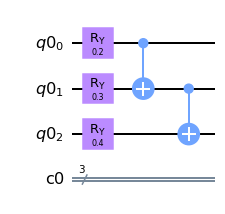

In [16]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,[0.2,0.3,0.4])

tst.draw(output = 'mpl')

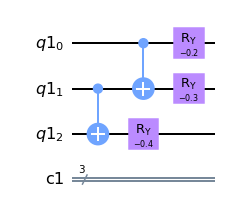

In [17]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)

tst_dagger = Ui_dagger(cir_i,[0.2,0.3,0.4])
tst_dagger.draw(output = 'mpl')

In [18]:
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir

def U_dagger(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui_dagger(cir,phi_b[T-1-t])
    return cir

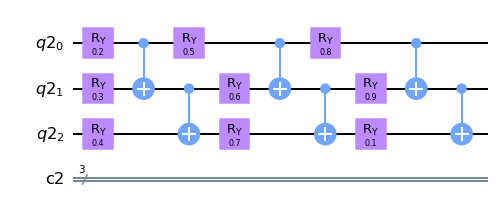

In [19]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

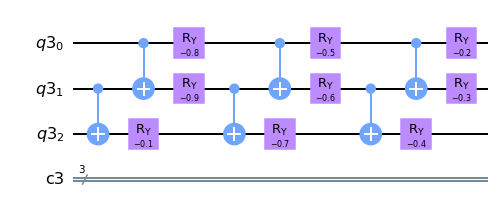

In [20]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U_dagger(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

First we need to inialize our set of parameters.  To do this we need to decide on the number of times we will apply Ui.  As a first attempt let's just have a depth of 1 (i.e. $U = Ui$).  

In this case, we need a parameter for each qubit for each section.

In [21]:
#number of blocks
T = 1

phi = []
for b in range(bL):
    phi_b = []
    for t in range(T):
        phi_t = []
        for q in range(Q):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)

The structure of $\phi_{b,t,q}$ is by section in the first index, by number of application of $U_i$ in the second index, and by qubit in the third index

Instead of using circuits to find $E$ I will convert $U$ into a statevector and each block into a matrix.  This should run faster so that we can explore the parameters in SPSA.

In [22]:
import copy

In [23]:
from qiskit import quantum_info as qi

def bkt(psi2,h,psi1):
    return np.dot(np.conjugate(psi2),np.dot(h,psi1))



def E_From_Matrix(phi,blocks):
    E = 0
    for key in list(blocks.keys()):
        qr = QuantumRegister(Q)
        cr = ClassicalRegister(Q)
        cir0 = QuantumCircuit(qr , cr)
        a = int(key.split(',')[0])
        b = int(key.split(',')[1])
        w = 1
        if a != b:
            w = 2
        cir = copy.deepcopy(cir0)
        psi_1 = qi.Statevector.from_instruction(U(cir,phi[b])).data
        h = blocks[key].to_matrix()
        cir = copy.deepcopy(cir0)
        psi_2 = qi.Statevector.from_instruction(U(cir,phi[a])).data
        E_key = bkt(psi_2,h,psi_1)
        E += w*E_key
    return E/bL
            

In [24]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
qi.Statevector.from_instruction(U(cir,phi[0])).data

E_From_Matrix(phi,blocks)

(-0.3333333333333333+0j)

For a sanity check, let's compare this to simple matrix multiplication

In [25]:
all_down = [0 for i in range(len(H))]
for b in range(bL):
    all_down[bL*b + 1] = 1/np.sqrt(bL)
    
np.dot(all_down,np.dot(H,all_down))

-0.3333333333333334

# Optimization

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [111]:
def SPSA(k_max,hold = False):
    #Initalization
    k = 0
    #alpha = 0.602
    alpha = 0.201
    A = 10
    a = 0.6
    gamma = 0.101
    c = 0.4
    phi_k = np.array(phi)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**alpha)
        c_k = c/((k + 1)**gamma)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
            
        #Find E    
        E_A = E_From_Matrix(phi_k + c_k*Delta_k ,blocks)
        E_B = E_From_Matrix(phi_k - c_k*Delta_k ,blocks)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k

        
        #Calculate new E
        E_f = np.real(E_From_Matrix(phi_k,blocks))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [133]:
out = SPSA(500,hold=True)

k= 0 c_k= 0.4 a_k= 0.37053677789517936 g= 0.3122123716656088 E_A= (0.6483890629959143+0j) E_B= (0.39861916566342726+0j) E_f= -0.2941674404659663
k= 1 c_k= 0.372954594574733 a_k= 0.36411269399518237 g= -0.2660003542034089 E_A= (0.29016140589224104+0j) E_B= (0.4885735144095765+0j) E_f= -0.2754518896461001
k= 2 c_k= 0.3579898757427053 a_k= 0.35830150846605 g= -0.23292677706300233 E_A= (0.2971946976524312+0j) E_B= (0.4639655536082972+0j) E_f= -0.2587121931480517
k= 3 c_k= 0.34773782403600867 a_k= 0.3530039095073033 g= 0.2123402114687735 E_A= (0.4327031217365754+0j) E_B= (0.28502567555358094+0j) E_f= -0.24596242903855295
k= 4 c_k= 0.33998833831625347 a_k= 0.3481423907099719 g= -0.8282619743549203 E_A= (0.03284742681671144+0j) E_B= (0.596046251519649+0j) E_f= -0.08100027444187827
k= 5 c_k= 0.3337849224236992 a_k= 0.3436553693939271 g= -0.7447356728411797 E_A= (0.21150410717356444+0j) E_B= (0.7086671847444737+0j) E_f= 0.038152202417289005
k= 6 c_k= 0.32862839767254015 a_k= 0.3394931510171673 

k= 52 c_k= 0.267860162826851 a_k= 0.2609058398079971 g= -0.663778100245506 E_A= (-1.097147455304283+0j) E_B= (-0.741548035278965+0j) E_f= -1.0994263698402236
k= 53 c_k= 0.26735494522142605 a_k= 0.26008126905440593 g= 1.4079113540821158 E_A= (-0.5476712911724912+0j) E_B= (-1.300495417066987+0j) E_f= -1.27509086049961
k= 54 c_k= 0.2668599250350944 a_k= 0.2592720285936403 g= 0.3115613639478629 E_A= (-1.010449945965103+0j) E_B= (-1.17673643041902+0j) E_f= -1.2814667599546914
k= 55 c_k= 0.26637471655715955 a_k= 0.25847760404433856 g= 0.11711483716032302 E_A= (-1.0275925370046752+0j) E_B= (-1.0899854001111131+0j) E_f= -1.2818743830349044
k= 56 c_k= 0.2658989552298248 a_k= 0.2576975057492954 g= 0.5293579784046012 E_A= (-0.8792011062133336+0j) E_B= (-1.1607125730140448+0j) E_f= -1.282086350580812
k= 57 c_k= 0.26543229614067565 a_k= 0.2569312672388709 g= -0.1394676022675081 E_A= (-1.0908689506251905+0j) E_B= (-1.0168305388109922+0j) E_f= -1.280162827098486
k= 58 c_k= 0.26497441264651617 a_k= 0.

k= 103 c_k= 0.25023014297472496 a_k= 0.23158657254318332 g= 0.16197514333165372 E_A= (-1.5241987206105998+0j) E_B= (-1.6052608471590624+0j) E_f= -1.7613944770531864
k= 104 c_k= 0.24998840873867942 a_k= 0.23118038596666274 g= -0.1055969092218814 E_A= (-1.6104547880019988+0j) E_B= (-1.557658781393797+0j) E_f= -1.7617568299887418
k= 105 c_k= 0.24974919607452548 a_k= 0.2307784194017882 g= 0.23095575564585205 E_A= (-1.5114396716308875+0j) E_B= (-1.6268017002335597+0j) E_f= -1.7663220086037097
k= 106 c_k= 0.2495124552599996 a_k= 0.23038059318858709 g= 0.3594327829764079 E_A= (-1.4573368947696426+0j) E_B= (-1.6367028071323988+0j) E_f= -1.7735644700799997
k= 107 c_k= 0.24927813800651724 a_k= 0.22998682983541768 g= 0.34594816844769777 E_A= (-1.506252183827229+0j) E_B= (-1.678726814382043+0j) E_f= -1.7811162902241553
k= 108 c_k= 0.24904619740500722 a_k= 0.22959705394216187 g= -0.07873932143334056 E_A= (-1.6728575169562547+0j) E_B= (-1.6336380597778066+0j) E_f= -1.7823494830513182
k= 109 c_k= 0.2

k= 153 c_k= 0.24050294487280224 a_k= 0.21526213181371276 g= 0.008744785336372187 E_A= (-1.70124064173634+0j) E_B= (-1.705446934987696+0j) E_f= -1.8713081976727524
k= 154 c_k= 0.24034577371294386 a_k= 0.2149992661706627 g= 0.22835649338188127 E_A= (-1.643593320004415+0j) E_B= (-1.753362356172901+0j) E_f= -1.8746302585197498
k= 155 c_k= 0.2401897150315199 a_k= 0.2147383069429348 g= -0.11426817501445533 E_A= (-1.717079195162217+0j) E_B= (-1.6621871143744293+0j) E_f= -1.8751852786256047
k= 156 c_k= 0.24003475389827156 a_k= 0.21447922894421484 g= -0.2818809676230336 E_A= (-1.7809006922846582+0j) E_B= (-1.6455782349006551+0j) E_f= -1.8829435060946698
k= 157 c_k= 0.23988087567680955 a_k= 0.21422200746922634 g= -0.1585448649171969 E_A= (-1.6936271332024966+0j) E_B= (-1.6175633711416992+0j) E_f= -1.8841169073226292
k= 158 c_k= 0.239728066017013 a_k= 0.21396661828174487 g= -0.16711155153215645 E_A= (-1.7323649605872706+0j) E_B= (-1.652242302471458+0j) E_f= -1.8846123935717067
k= 159 c_k= 0.23957

k= 203 c_k= 0.23376922896323718 a_k= 0.20405069669827428 g= 0.13578834536009052 E_A= (-1.6945963510230373+0j) E_B= (-1.7580826246170815+0j) E_f= -1.9496523984210885
k= 204 c_k= 0.23365380153244633 a_k= 0.2038595775662753 g= -0.05541738633235996 E_A= (-1.763891442131468+0j) E_B= (-1.7379944761563717+0j) E_f= -1.95043716596448
k= 205 c_k= 0.23353899237344763 a_k= 0.20366952306447533 g= -0.11792461007269195 E_A= (-1.7959479708233803+0j) E_B= (-1.740867981598564+0j) E_f= -1.9518037972365214
k= 206 c_k= 0.23342479519724088 a_k= 0.20348052237451628 g= -0.09071368922305481 E_A= (-1.6991096595159274+0j) E_B= (-1.656760010858972+0j) E_f= -1.9520031840421197
k= 207 c_k= 0.23331120380879006 a_k= 0.20329256483718383 g= 0.04834231058198285 E_A= (-1.7528395583647616+0j) E_B= (-1.7753971637183232+0j) E_f= -1.9525761027164403
k= 208 c_k= 0.2331982121051757 a_k= 0.20310563994934921 g= -0.09358322205141477 E_A= (-1.7761447814022011+0j) E_B= (-1.732497901271338+0j) E_f= -1.9536927717094694
k= 209 c_k= 0.

k= 253 c_k= 0.22865030548461726 a_k= 0.19561802104402623 g= 0.049325829073939384 E_A= (-1.7798753465321833+0j) E_B= (-1.8024320783042598+0j) E_f= -1.9759434919769103
k= 254 c_k= 0.22855958199258958 a_k= 0.19546942243156754 g= -0.05722059583899568 E_A= (-1.7982637636729475+0j) E_B= (-1.772107132740292+0j) E_f= -1.9763447043090343
k= 255 c_k= 0.22846924936970905 a_k= 0.19532149575799884 g= 0.05709263782041697 E_A= (-1.7882460155971374+0j) E_B= (-1.814333839811872+0j) E_f= -1.976679824785816
k= 256 c_k= 0.22837930441497245 a_k= 0.19517423547591145 g= 0.03177957709390673 E_A= (-1.8018249827328572+0j) E_B= (-1.816340578155474+0j) E_f= -1.9768890717704368
k= 257 c_k= 0.22828974396591784 a_k= 0.1950276361042541 g= 0.03729601650757146 E_A= (-1.7911134831045237+0j) E_B= (-1.808142079223448+0j) E_f= -1.9768232738242557
k= 258 c_k= 0.22820056489801344 a_k= 0.19488169222729543 g= 0.006766089520061639 E_A= (-1.820123037684761+0j) E_B= (-1.8232110885860182+0j) E_f= -1.9768788105756336
k= 259 c_k= 0.

k= 303 c_k= 0.2245379531555281 a_k= 0.1889158475879403 g= -0.019615701884671804 E_A= (-1.760203835701752+0j) E_B= (-1.7513948965999655+0j) E_f= -1.9803283412163797
k= 304 c_k= 0.22446348815402628 a_k= 0.18879514811017423 g= -0.015041963527364395 E_A= (-1.8075114416264992+0j) E_B= (-1.8007586984224235+0j) E_f= -1.9804480317890931
k= 305 c_k= 0.22438929147512626 a_k= 0.1886749079481776 g= -0.00537915972719703 E_A= (-1.7702282511470537+0j) E_B= (-1.7678141994672192+0j) E_f= -1.9804321975331285
k= 306 c_k= 0.2243153612798253 a_k= 0.18855512390879003 g= -0.034871426066509906 E_A= (-1.7960331364346234+0j) E_B= (-1.7803887433617196+0j) E_f= -1.980519972210309
k= 307 c_k= 0.2242416957476633 a_k= 0.18843579283103418 g= -0.03206633912026647 E_A= (-1.798684850507945+0j) E_B= (-1.7843036299864485+0j) E_f= -1.980643996427384
k= 308 c_k= 0.22416829307647623 a_k= 0.1883169115856913 g= 0.016437240735651497 E_A= (-1.8042523980589025+0j) E_B= (-1.8116218144560987+0j) E_f= -1.9806908605402183
k= 309 c_k=

k= 353 c_k= 0.22111115942370668 a_k= 0.18338756003289805 g= 0.03882221520855667 E_A= (-1.7998008757955741+0j) E_B= (-1.8169689258278954+0j) E_f= -1.9820295317492294
k= 354 c_k= 0.2210481719458794 a_k= 0.18328646055073458 g= 0.007150945813136034 E_A= (-1.81592745348493+0j) E_B= (-1.8190888604842854+0j) E_f= -1.9820104730152732
k= 355 c_k= 0.22098537951573047 a_k= 0.18318569318138667 g= -0.0019019534642675433 E_A= (-1.8242452398534958+0j) E_B= (-1.823404632037251+0j) E_f= -1.9820130283647295
k= 356 c_k= 0.22092278098392504 a_k= 0.18308525593090869 g= -0.003870688735277729 E_A= (-1.8230589603195697+0j) E_B= (-1.8213487136801283+0j) E_f= -1.9819954953320185
k= 357 c_k= 0.2208603752110963 a_k= 0.1829851468227179 g= -0.027559669595949104 E_A= (-1.7940244271544608+0j) E_B= (-1.7818507492191504+0j) E_f= -1.9818850452459345
k= 358 c_k= 0.22079816106773162 a_k= 0.1828853638973968 g= -0.025775513851475147 E_A= (-1.7944604951253125+0j) E_B= (-1.7830781230073494+0j) E_f= -1.9820153057785108
k= 359 

k= 404 c_k= 0.2181257984204375 a_k= 0.17861732579176134 g= -0.013979438045243415 E_A= (-1.8192733892152475+0j) E_B= (-1.813174837045072+0j) E_f= -1.982166292507289
k= 405 c_k= 0.2180714754281335 a_k= 0.17853093970918948 g= 0.004043741360279886 E_A= (-1.7976272361660897+0j) E_B= (-1.7993908854554617+0j) E_f= -1.9821446936108826
k= 406 c_k= 0.2180172995508166 a_k= 0.17844480266562 g= 0.005504211774598298 E_A= (-1.7852497522691577+0j) E_B= (-1.7876497790436652+0j) E_f= -1.9821313434825756
k= 407 c_k= 0.21796327003008015 a_k= 0.17835891334846937 g= 0.001172244332954579 E_A= (-1.8010866334720008+0j) E_B= (-1.8015976458881708+0j) E_f= -1.9821261851195628
k= 408 c_k= 0.2179093861132739 a_k= 0.1782732704551914 g= 0.009614786443255622 E_A= (-1.8063669744072766+0j) E_B= (-1.8105572788301967+0j) E_f= -1.982162633667444
k= 409 c_k= 0.21785564705344662 a_k= 0.1781878726931765 g= -0.007000593577236815 E_A= (-1.7786967005821457+0j) E_B= (-1.7756464628950914+0j) E_f= -1.982122289676361
k= 410 c_k= 0.2

k= 454 c_k= 0.21557621389665993 a_k= 0.17457948453338862 g= 0.019198286625147932 E_A= (-1.8247353705263614+0j) E_B= (-1.833012758414266+0j) E_f= -1.982763771146534
k= 455 c_k= 0.21552841852324142 a_k= 0.17450411844306418 g= -0.011228681778112556 E_A= (-1.803329787273988+0j) E_B= (-1.7984895872225133+0j) E_f= -1.982746940304918
k= 456 c_k= 0.21548073841143345 a_k= 0.17442894634039197 g= -0.005746230407612265 E_A= (-1.78945890456785+0j) E_B= (-1.786982500625221+0j) E_f= -1.9827223173735788
k= 457 c_k= 0.2154331730319722 a_k= 0.1743539673122692 g= -0.007685584631080105 E_A= (-1.8168967167008216+0j) E_B= (-1.813585256933463+0j) E_f= -1.982698540340729
k= 458 c_k= 0.21538572185917312 a_k= 0.1742791804518308 g= 0.012480387012741045 E_A= (-1.8024065282897346+0j) E_B= (-1.8077827226213767+0j) E_f= -1.9826947169522446
k= 459 c_k= 0.2153383843708989 a_k= 0.17420458485839307 g= -0.028735865899319386 E_A= (-1.7972119223676266+0j) E_B= (-1.7848360524951101+0j) E_f= -1.982585455397825
k= 460 c_k= 0.

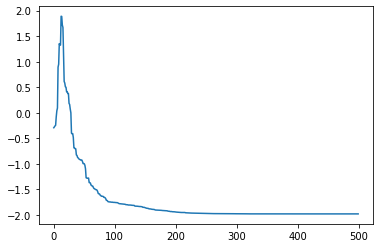

In [134]:
import matplotlib.pyplot as plt

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [135]:
phi_f = out[len(out)-1]['phi']

E_From_Matrix(phi_f,blocks)

(-1.9823161057295846+0j)

In [136]:
np.sort(e)

array([-3.34084762e+00+0.00000000e+00j, -3.29295138e+00+0.00000000e+00j,
       -2.86387634e+00+0.00000000e+00j, -2.78526086e+00+0.00000000e+00j,
       -1.56155281e+00+0.00000000e+00j, -1.56155281e+00+0.00000000e+00j,
       -1.00000000e+00+0.00000000e+00j, -1.00000000e+00+0.00000000e+00j,
       -1.00000000e+00+0.00000000e+00j, -1.00000000e+00+0.00000000e+00j,
       -5.61552813e-01+0.00000000e+00j, -5.61552813e-01+0.00000000e+00j,
        7.31507328e-16+0.00000000e+00j,  5.07690516e-01+0.00000000e+00j,
        5.23028722e-01+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00-1.27192026e-16j,
        1.00000000e+00+1.27192026e-16j,  1.47697128e+00+0.00000000e+00j,
        1.49230948e+00+0.00000000e+00j,  2.00000000e+00+0.00000000e+00j,
        2.56155281e+00+0.00000000e+00j,  2.56155281e+00+0.00000000e+00j,
        3.00000000e+00+0.00000000e+00j,  3.00000000

In [139]:
import pickle

file_to_store = open("VQE_Example.pickle", "wb")

pickle.dump(out, file_to_store)

In [1]:
import pickle

file_to_read = open("VQE_Example.pickle", "rb")

loaded_object = pickle.load(file_to_read)

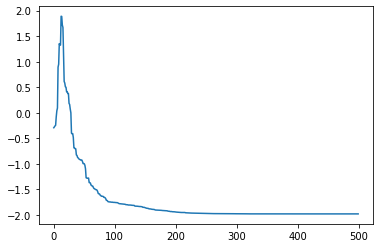

In [2]:
import matplotlib.pyplot as plt

El = [loaded_object[i]['E'] for i in range(len(loaded_object))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [5]:
loaded_object[0]['Delta']

array([[[ 1, -1, -1]],

       [[-1,  1,  1]],

       [[ 1, -1, -1]],

       [[ 1, -1,  1]],

       [[-1, -1,  1]],

       [[ 1, -1,  1]]])